<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Logistic Regression Training Negative Log likelihood (Cross-Entropy)</h1> 

<h2>Table of Contents</h2>
<p>In this lab, you will see what happens when you use the Cross-Entropy or total loss function using random initialization for a parameter value.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Create the Model and Cost Function the PyTorch way </a></li>
    <li><a href="#BGD">Train the Model: Batch Gradient Descent</a></li>
</ul>
<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>

<h2>Preparation</h2>

We'll need the following libraries:

In [1]:
## Import the libraries we need for this lab

import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch. 

In [2]:
# Create class for plotting and the function for plotting

class PlotErrorSurfaces(object):
    ## Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        self.y, self.x = Y.numpy(), X.numpy()
        for ix, (w1, b1) in enumerate(zip(w, b)):
            for jx, (w2, b2) in enumerate(zip(w1, b1)):
                yhat = 1. / (1 + np.exp(-1*(w2 * self.x + b2)))
                Z[ix, jx] = -1 * np.mean(self.y * np.log(yhat + 1e-16) + 
                                         (1 - self.y) * np.log(1 - yhat + 1e-16))
        self.Z, self.w, self.b = Z, w, b
        self.W, self.B = [], []
        self.LOSS = []
        self.n = 0
        if go:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    ## Setter
    def set_para_loss(self, model, loss):
        self.n += 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    ## Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    ## Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
## Plot the diagram
def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg:
        plt.legend()
    else:
        pass

Set the random seed:

In [3]:
## Set random seed
torch.manual_seed(0)

<h2 id="Makeup_Data">Get Some Data</h2>

In [4]:
## Create the data class
class Data(Dataset):
    ## Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]
    
    ## Getter
    def __getitem__(self, ix):      
        return self.x[ix], self.y[ix]
    
    ## Get length
    def __len__(self):
        return self.len

Make <code>Data</code> object

In [5]:
## Create Data object
data_set = Data()

<h2 id="Model_Cost">Create the Model and Total Loss Function (Cost)</h2>

Create a custom module for logistic regression:

In [6]:
## Create logistic_regression class

class LogisticRegression(nn.Module):
    ## Constructor
    def __init__(self, n_inputs):
        super().__init__() # super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    ## Prediction
    def forward(self, x):
        return torch.sigmoid(self.linear(x)) # yhat

Create a logistic regression object or model: 

In [8]:
## Create the logistic_regression result

model = LogisticRegression(1)

Replace the random initialized variable values. Theses random initialized variable values did convergence for the RMS Loss but will converge for the Cross-Entropy Loss.

In [9]:
## Set the weight and bias

model.state_dict() ['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict() ['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict([('linear.weight', tensor([[-5.]])), ('linear.bias', tensor([-10.]))])


Create a <code> PlotErrorSurfaces</code> object to visualize the data space and the parameter space during training:

<Figure size 432x288 with 0 Axes>

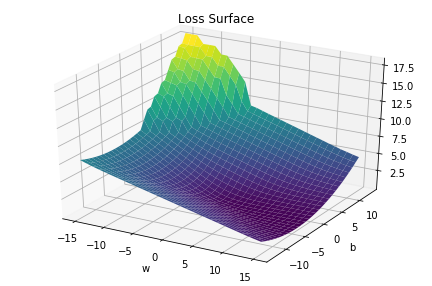

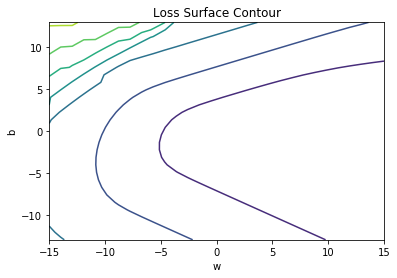

In [10]:
## Create the PlotErrorSurfaces object

get_surface = PlotErrorSurfaces(15, 13, data_set[:][0], data_set[:][1], 30)

Define the cost or criterion function: 

In [11]:
## Create dataloader, criterion function and optimizer

def criterion(yhat, y):
    out = -1 * torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return out

# Built in criterion
# criterion = nn.BCELoss()

trainloader = DataLoader(dataset = data_set, batch_size = 3)
learning_rate = 2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

<h2 id="BGD">Train the Model via Batch Gradient Descent</h2>

Train the model

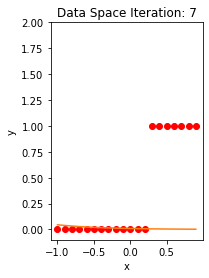

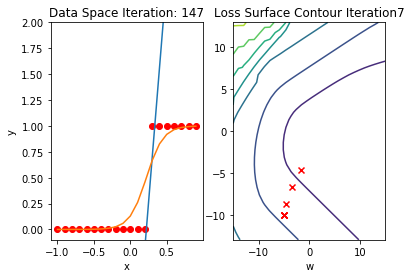

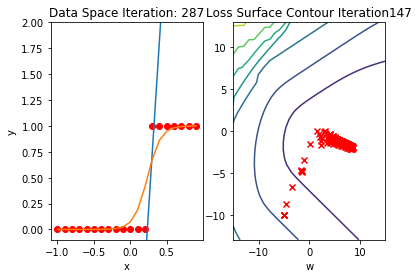

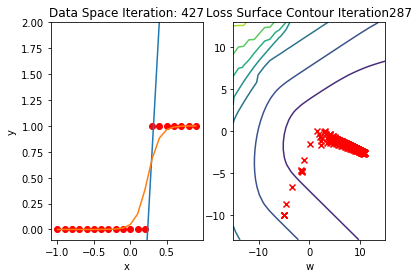

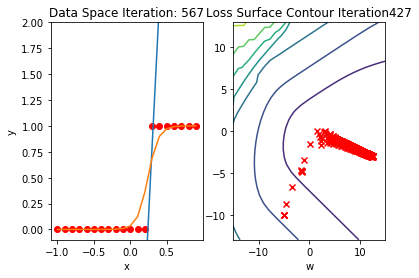

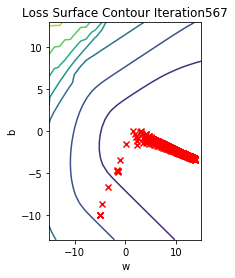

In [12]:
## Train the Model

def train_model(epochs):
    for epoch in range(epochs):
        for x, y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            get_surface.set_para_loss(model, loss.tolist())
        if epoch % 20 == 0:
            get_surface.plot_ps()
            
train_model(100)

Get the actual class of each sample and calculate the accuracy on the test data:

In [13]:
## Make the Prediction

yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(1.)


The accuracy is perfect.  

#### Alt.

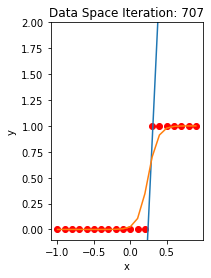

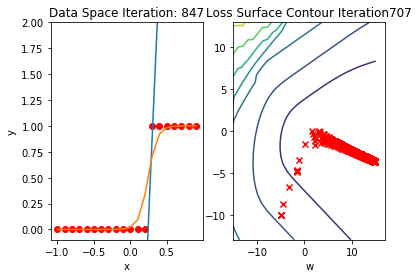

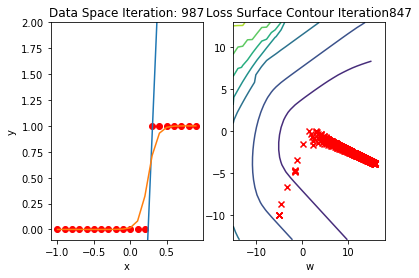

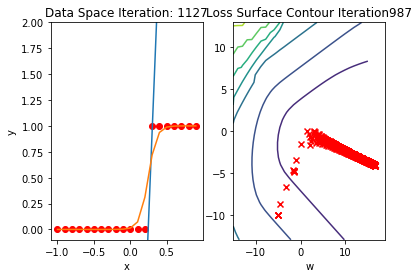

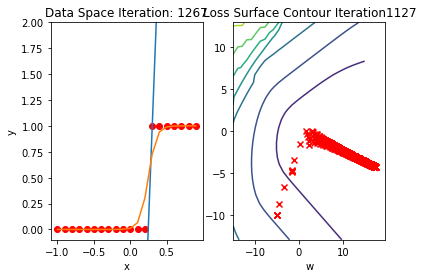

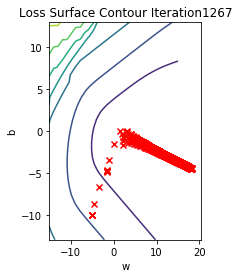

In [15]:
# Built-in criterion (Binary Cross Entropy Loss)
criterion = nn.BCELoss()

trainloader = DataLoader(dataset = data_set, batch_size = 3)
learning_rate = 2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_model(100)

In [16]:
## Make the Prediction

yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(1.)



<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.